In [124]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import config
import random
from itertools import chain
from scipy.stats.stats import ttest_ind
from scipy import stats
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest

%matplotlib inline
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [126]:
postgres_user = config.user
postgres_pw = config.password
postgres_host = config.host
postgres_port = config.port
postgres_db = "lifeexpectancy"
table_name = "lifeexpectancy"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

df = pd.read_sql_query("select * from lifeexpectancy", con=engine)

# No need for an open connection,
# because you're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


<IPython.core.display.Javascript object>

Your goal in this challenge is to find the factors that affect life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

1. First, load the dataset.

2. Detect the problems with the data, such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable for filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

3. Explore the data using univariate and multivariate exploration techniques. Be sure to pay special attention to your target variable. In this regard, focus on finding the relevant variables that may affect life expectancy.

4. In the feature-engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are highly correlated with the other ones or the variables that you think are irrelevant with the life expectancy.

5. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization

## 2. Detect the problems with the data, such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable for filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

<IPython.core.display.Javascript object>

In [6]:
df.isnull().sum().sort_values(ascending=False) / len(df)

Population                         0.221920
Hepatitis B                        0.188223
GDP                                0.152485
Total expenditure                  0.076923
Alcohol                            0.066031
Income composition of resources    0.056841
Schooling                          0.055480
 BMI                               0.011572
 thinness  1-19 years              0.011572
 thinness 5-9 years                0.011572
Diphtheria                         0.006467
Polio                              0.006467
Adult Mortality                    0.003404
Life expectancy                    0.003404
under-five deaths                  0.000000
 HIV/AIDS                          0.000000
Measles                            0.000000
percentage expenditure             0.000000
infant deaths                      0.000000
Status                             0.000000
Year                               0.000000
Country                            0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [101]:
year = df["Year"].unique()
p = "Population"

df1 = df.copy()
for i in year:
    df1.loc[df1["Year"] == i, p] = df1.loc[df1["Year"] == i, p].fillna(
        df1[df1["Year"] == i][p].mean()
    )
df2 = df.copy()
for i in year:
    df2.loc[df2["Year"] == i, p] = df2.loc[df2["Year"] == i, p].fillna(
        df2[df2["Year"] == i][p].interpolate()
    )
df3 = df.copy()
for i in year:
    df3.loc[df3["Year"] == i, p] = df3.loc[df3["Year"] == i, p].fillna(
        df3[df3["Year"] == i][p].median()
    )

<IPython.core.display.Javascript object>

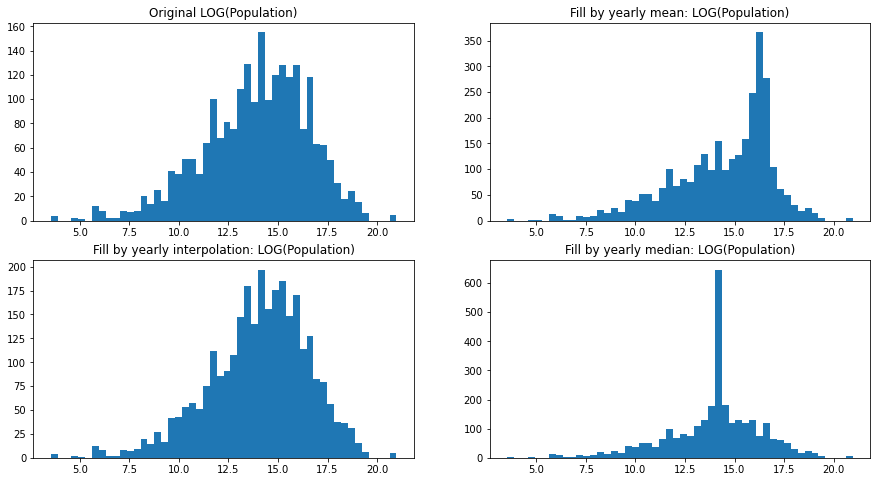

<IPython.core.display.Javascript object>

In [102]:
plt.figure(figsize=(15, 8))
plt.subplot(221)
plt.hist(x=np.log(df[p]), bins=50)
plt.title("Original LOG(Population)")

plt.subplot(222)
plt.hist(x=np.log(df1[p]), bins=50)
plt.title("Fill by yearly mean: LOG(Population)")

plt.subplot(223)
plt.hist(x=np.log(df2[p]), bins=50)
plt.title("Fill by yearly interpolation: LOG(Population)")

plt.subplot(224)
plt.hist(x=np.log(df3[p]), bins=50)
plt.title("Fill by yearly median: LOG(Population)")
plt.show()

In [115]:
df2.isnull().sum().sort_values(ascending=False) / len(df)

Hepatitis B                        0.188223
GDP                                0.152485
Total expenditure                  0.076923
Alcohol                            0.066031
Income composition of resources    0.056841
Win_BOXCOX(Schooling)              0.055480
BOXCOX(Schooling)                  0.055480
Win_LOG(Schooling)                 0.055480
LOG(Schooling)                     0.055480
Schooling                          0.055480
 BMI                               0.011572
 thinness 5-9 years                0.011572
 thinness  1-19 years              0.011572
Polio                              0.006467
Diphtheria                         0.006467
LOG(LifeEx)                        0.003404
BOXCOX(LifeEx)                     0.003404
Win_BOXCOX(LifeEx)                 0.003404
Adult Mortality                    0.003404
Life expectancy                    0.003404
 HIV/AIDS                          0.000000
Population                         0.000000
under-five deaths               

<IPython.core.display.Javascript object>

In [9]:
df2 = df.copy()

fill_list = [
    "Population",
    "Hepatitis B",
    "GDP",
    "Total expenditure",
    "Alcohol",
    "Income composition of resources",
    "Schooling",
    " BMI ",
    " thinness  1-19 years",
    " thinness 5-9 years",
    "Diphtheria ",
    "Polio",
    "Adult Mortality",
    "Life expectancy ",
    " HIV/AIDS",
]

for col in fill_list:
    for i in year:
        df2.loc[df2["Year"] == i, col] = df2.loc[df2["Year"] == i, col].fillna(
            df2[df2["Year"] == i][col].interpolate()
        )

<IPython.core.display.Javascript object>

In [97]:
df2["LOG(Population)"] = np.log(df2[p])

<IPython.core.display.Javascript object>

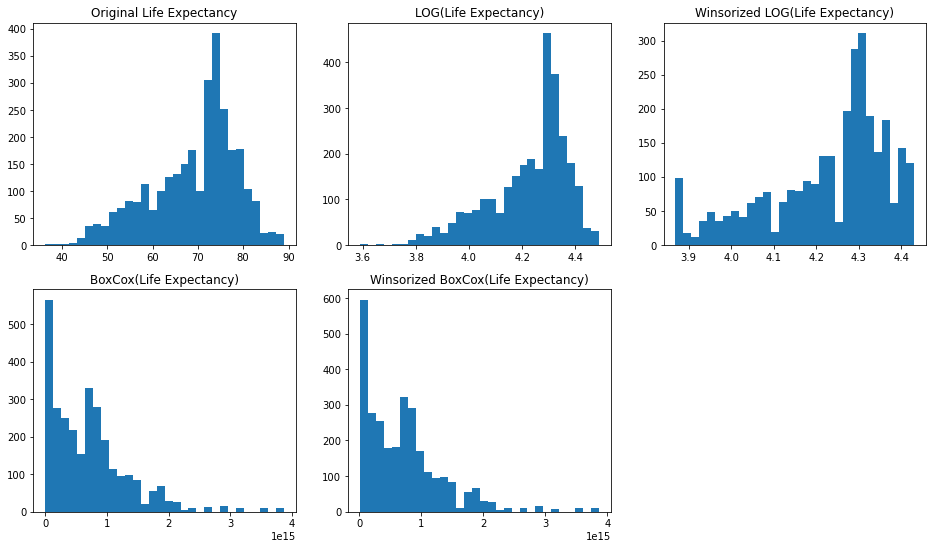

<IPython.core.display.Javascript object>

In [106]:
plt.figure(figsize=(16, 9))
plt.subplot(231)
plt.hist(x=df2["Life expectancy "], bins=30)
plt.title("Original Life Expectancy")

df2["LOG(LifeEx)"] = np.log(df2["Life expectancy "])

plt.subplot(232)
plt.hist(x=df2["LOG(LifeEx)"], bins=30)
plt.title("LOG(Life Expectancy)")

df2["Win_LOG(LifeEx)"] = winsorize(df2["LOG(LifeEx)"], (0.025, 0.025))

plt.subplot(233)
plt.hist(x=df2["Win_LOG(LifeEx)"], bins=30)
plt.title("Winsorized LOG(Life Expectancy)")

df2["BOXCOX(LifeEx)"], _ = boxcox(df2["Life expectancy "])

plt.subplot(234)
plt.hist(x=df2["BOXCOX(LifeEx)"], bins=30)
plt.title("BoxCox(Life Expectancy)")

df2["Win_BOXCOX(LifeEx)"] = winsorize(df2["BOXCOX(LifeEx)"], (0.02, 0.0))

plt.subplot(235)
plt.hist(x=df2["Win_BOXCOX(LifeEx)"], bins=30)
plt.title("Winsorized BoxCox(Life Expectancy)")
plt.show()

In [107]:
df2.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling', 'LOG(LifeEx)',
       'Win_LOG(LifeEx)', 'BOXCOX(LifeEx)', 'Win_BOXCOX(LifeEx)'],
      dtype='object')

<IPython.core.display.Javascript object>

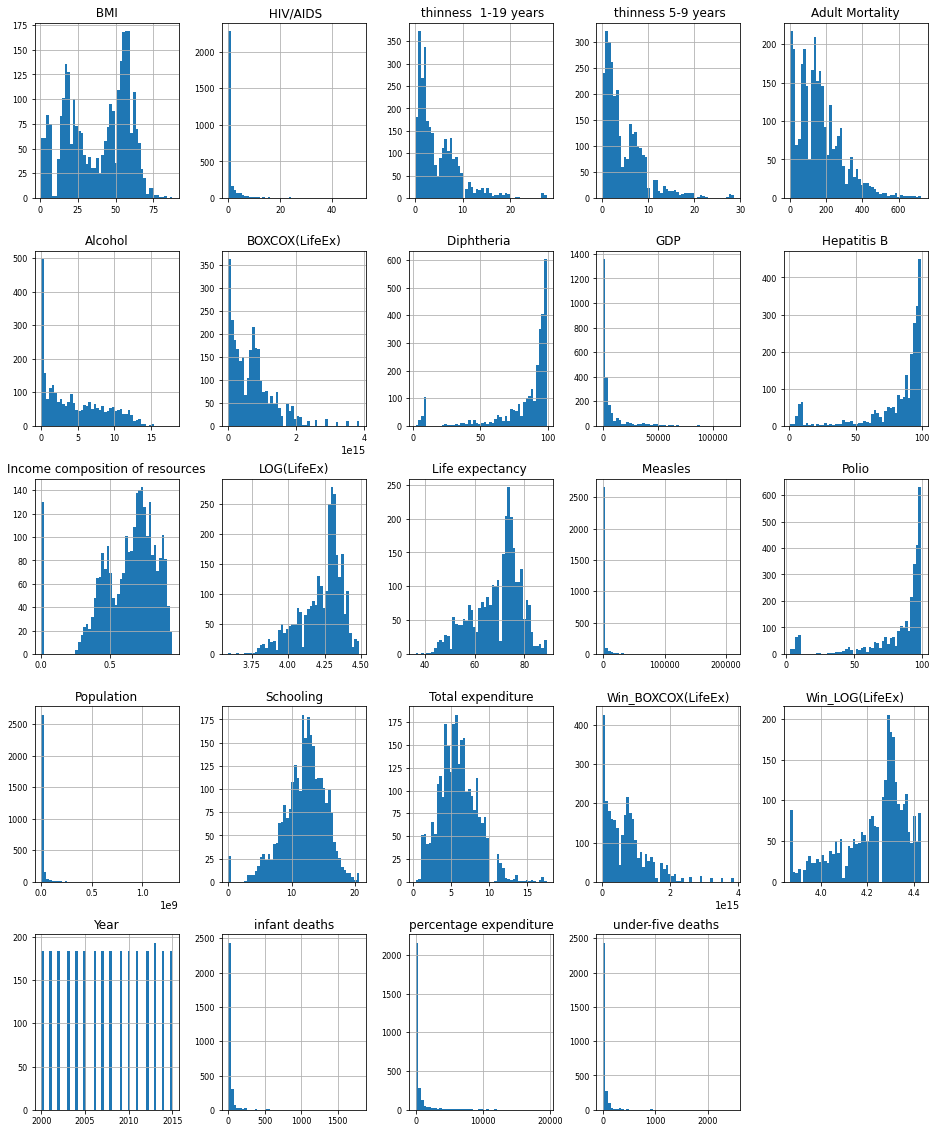

<IPython.core.display.Javascript object>

In [108]:
df2.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [109]:
df_num_corr = df.corr()["Life expectancy "][:]  # -1 if 'a column'
golden_feature_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print(
    "There is {} strongly correlated values with a column:\n{}".format(
        len(golden_feature_list), golden_feature_list
    )
)

There is 6 strongly correlated values with a column:
Life expectancy                    1.000000
Schooling                          0.751975
Income composition of resources    0.724776
 BMI                               0.567694
 HIV/AIDS                         -0.556556
Adult Mortality                   -0.696359
Name: Life expectancy , dtype: float64


<IPython.core.display.Javascript object>

## 3. Explore the data using univariate and multivariate exploration techniques. Be sure to pay special attention to your target variable. In this regard, focus on finding the relevant variables that may affect life expectancy.

In [95]:
stats.kruskal(
    df2[df2["Status"] == "Developing"]["Life expectancy "],
    df2[df2["Status"] == "Developed"]["Life expectancy "],
)

KruskalResult(statistic=873.6932239423763, pvalue=5.136790999904708e-192)

<IPython.core.display.Javascript object>

In [96]:
stats.kruskal(
    df2[df2["Status"] == "Developing"]["LifeEx_boxcox"],
    df2[df2["Status"] == "Developed"]["LifeEx_boxcox"],
)

KruskalResult(statistic=873.6932375853953, pvalue=5.136755919340867e-192)

<IPython.core.display.Javascript object>

This Kruskal-Wallis test shows that there is a significant difference in 'Life expenctancy' between the 'developing' and 'developed' countries.

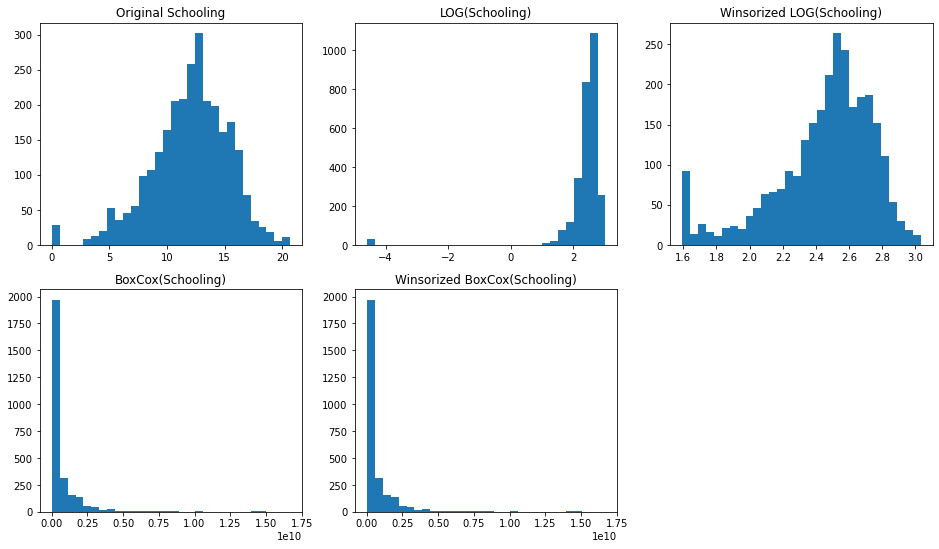

<IPython.core.display.Javascript object>

In [110]:
plt.figure(figsize=(16, 9))
plt.subplot(231)
plt.hist(x=df2["Schooling"], bins=30)
plt.title("Original Schooling")

df2["LOG(Schooling)"] = np.log(df2["Schooling"].apply(lambda x: x + 0.01))

plt.subplot(232)
plt.hist(x=df2["LOG(Schooling)"], bins=30)
plt.title("LOG(Schooling)")

df2["Win_LOG(Schooling)"] = winsorize(df2["LOG(Schooling)"], (0.025, 0.025))

plt.subplot(233)
plt.hist(x=df2["Win_LOG(Schooling)"], bins=30)
plt.title("Winsorized LOG(Schooling)")

df2["BOXCOX(Schooling)"], _ = boxcox(df2["Schooling"].apply(lambda x: x + 0.01))

plt.subplot(234)
plt.hist(x=df2["BOXCOX(Schooling)"], bins=30)
plt.title("BoxCox(Schooling)")

df2["Win_BOXCOX(Schooling)"] = winsorize(df2["BOXCOX(Schooling)"], (0.02, 0.05))

plt.subplot(235)
plt.hist(x=df2["Win_BOXCOX(Schooling)"], bins=30)
plt.title("Winsorized BoxCox(Schooling)")
plt.show()

In [20]:
# Take the log of the Schooling and calculate
# the quartiles accordingly.
q75, q25 = np.percentile(np.log(df2["Schooling"]), [75, 25])
iqr = q75 - q25

for threshold in np.arange(1, 5, 0.5):
    min_val = q25 - (iqr * threshold)
    max_val = q75 + (iqr * threshold)
    print("The score threshold is: {}".format(threshold))
    print(
        "Number of outliers is: {}".format(
            len(
                (
                    np.where(
                        (np.log(df2["Schooling"]) > max_val)
                        | (np.log(df2["Schooling"]) < min_val)
                    )[0]
                )
            )
        )
    )

The score threshold is: 1.0
Number of outliers is: 249
The score threshold is: 1.5
Number of outliers is: 153
The score threshold is: 2.0
Number of outliers is: 92
The score threshold is: 2.5
Number of outliers is: 55
The score threshold is: 3.0
Number of outliers is: 43
The score threshold is: 3.5
Number of outliers is: 35
The score threshold is: 4.0
Number of outliers is: 28
The score threshold is: 4.5
Number of outliers is: 28


<IPython.core.display.Javascript object>

In [21]:
from scipy.stats import zscore

z_scores = zscore(df2["Schooling"])
for threshold in range(1, 5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([  81,   82,   83,   84,   85,   86,   87,   88,   89,   90,   91,
         92,   93,   94,   95,  113,  114,  115,  116,  117,  118,  119,
        120,  121,  122,  123,  124,  125,  126,  127,  128,  129,  130,
        131,  132,  133,  134,  142,  143,  144,  213,  214,  215,  225,
        226,  227,  228,  229,  230,  231,  241,  242,  243,  244,  245,
        246,  247,  248,  249,  250,  251,  252,  253,  254,  255,  256,
        496,  497,  498,  499,  500,  501,  502,  503,  504,  505,  506,
        507,  508,  509,  510,  511,  544,  545,  546,  547,  548,  660,
        661,  662,  663,  664,  665,  689,  705,  706,  707,  708,  710,
        711,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,
        731,  732,  733,  734,  736,  737,  738,  739,  740,  741,  742,
        743,  744,  745,  746,  747,  748,  749,  750,  751,  752,  867,
        868,  869,  870,  871,  872,  873,  874,  875,  876,  877,  

<IPython.core.display.Javascript object>

For this variable, the outliers discovered with z-scores greater than a threshold of 2 will be dropped.

In [111]:
dlist = list(np.where(z_scores > 2)[0])

<IPython.core.display.Javascript object>

In [112]:
df2_2 = df2.copy()
df2_2 = df2_2.drop(dlist)

<IPython.core.display.Javascript object>

In [122]:
nanlist = df2_2.isnull().sum().sort_values(ascending=False) / len(df)
nanlist[0]

0.18822328114363512

<IPython.core.display.Javascript object>

In [123]:
df2 = df.copy()

fill_list = [
    "Population",
    "Hepatitis B",
    "GDP",
    "Total expenditure",
    "Alcohol",
    "Income composition of resources",
    "Schooling",
    "Win_BOXCOX(Schooling)",
    "BOXCOX(Schooling)",
    "LOG(Schooling)",
    "Win_LOG(Schooling)",
    "LOG(LifeEx)",
    "Win_LOG(LifeEx)",
    "BOXCOX(LifeEx)",
    "Win_BOXCOX(LifeEx)" " BMI ",
    " thinness  1-19 years",
    " thinness 5-9 years",
    "Diphtheria ",
    "Polio",
    "Adult Mortality",
    "Life expectancy ",
    " HIV/AIDS",
]

for col in fill_list:
    for i in year:
        df2.loc[df2["Year"] == i, col] = df2.loc[df2["Year"] == i, col].fillna(
            df2[df2["Year"] == i][col].interpolate()
        )

KeyError: 'Win_BOXCOX(Schooling)'

<IPython.core.display.Javascript object>

In [113]:
df2_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2938 entries, 0 to 2937
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

<IPython.core.display.Javascript object>

In [86]:
df2_2["Income composition of resources"].describe()

count    2938.00000
mean        0.63474
std         0.20940
min         0.00000
25%         0.50100
50%         0.68400
75%         0.78800
max         0.94800
Name: Income composition of resources, dtype: float64

<IPython.core.display.Javascript object>

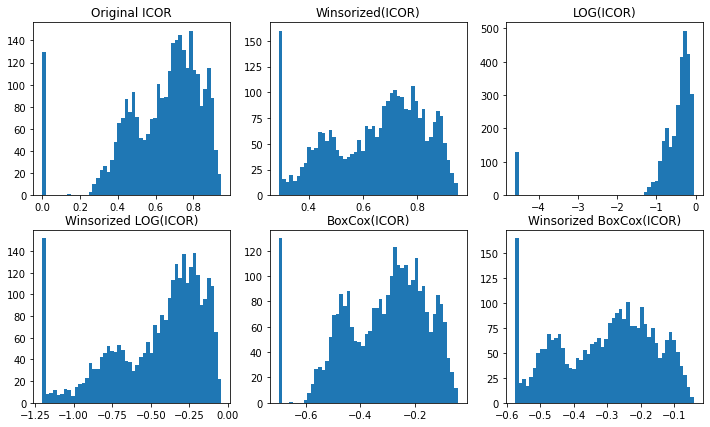

<IPython.core.display.Javascript object>

In [87]:
# shift the data by min_value + 0.1 to elminate value >= 0  and allow for Log transform
# data will need to be shifted back during post hoc analysis

df2_2["BoxCox(ICOR)"], _ = boxcox(
    df2_2["Income composition of resources"].apply(lambda x: x + 0.01)
)

df2_2["BoxCox(ICOR)"] = pd.to_numeric(df2_2["BoxCox(ICOR)"], errors="coerce")

df2_2["LOG(ICOR)"] = np.log(
    df2_2["Income composition of resources"].apply(lambda x: x + 0.01)
)
df2_2["LOG(ICOR)"] = pd.to_numeric(df2_2["LOG(ICOR)"], errors="coerce")

df2_2["winsor_ICOR"] = winsorize(df2_2["Income composition of resources"], (0.05, 0.0))
df2_2["Win_bcox_ICOR"] = winsorize(df2_2["BoxCox(ICOR)"], (0.05, 0.0))
df2_2["Win_LOG(ICOR)"] = winsorize(df2_2["LOG(ICOR)"], (0.05, 0.0))

plt.figure(figsize=(12, 7))
plt.subplot(231)
plt.hist(x=df2_2["Income composition of resources"], bins=50)
plt.title("Original ICOR")
plt.subplot(232)
plt.hist(x=df2_2["winsor_ICOR"], bins=50)
plt.title("Winsorized(ICOR)")
plt.subplot(233)
plt.hist(x=df2_2["LOG(ICOR)"], bins=50)
plt.title("LOG(ICOR)")
plt.subplot(234)
plt.hist(x=df2_2["Win_LOG(ICOR)"], bins=50)
plt.title("Winsorized LOG(ICOR)")
plt.subplot(235)
plt.hist(x=df2_2["BoxCox(ICOR)"], bins=50)
plt.title("BoxCox(ICOR)")
plt.subplot(236)
plt.hist(x=df2_2["Win_bcox_ICOR"], bins=50)
plt.title("Winsorized BoxCox(ICOR)")
plt.show()

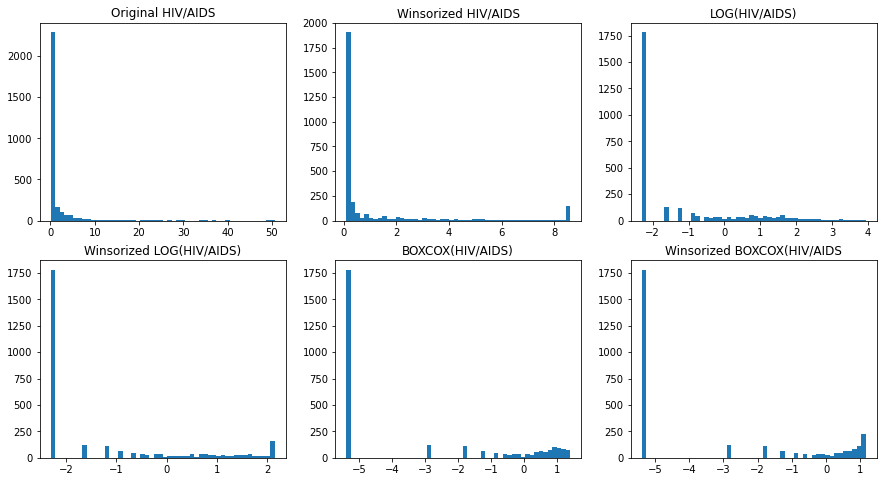

<IPython.core.display.Javascript object>

In [83]:
df2_2["Win_HIV/AIDS"] = winsorize(df2_2[" HIV/AIDS"], (0.05, 0.05))
df2_2["LOG(HIV/AIDS)"] = np.log(df2_2[" HIV/AIDS"])
df2_2["Win_LOG(HIV/AIDS)"] = winsorize(df2_2["LOG(HIV/AIDS)"], (0.05, 0.05))
df2_2["BOXCOX(HIV/AIDS)"], _ = boxcox(df2_2[" HIV/AIDS"])
df2_2["Win_BOXCOX(HIV/AIDS)"] = winsorize(df2_2["BOXCOX(HIV/AIDS)"], (0.05, 0.05))

plt.figure(figsize=(15, 8))
plt.subplot(231)
plt.title("Original HIV/AIDS")
plt.hist(x=df2_2[" HIV/AIDS"], bins=50)

plt.subplot(232)
plt.title("Winsorized HIV/AIDS")
plt.hist(x=df2_2["Win_HIV/AIDS"], bins=50)

plt.subplot(233)
plt.title("LOG(HIV/AIDS)")
plt.hist(x=df2_2["LOG(HIV/AIDS)"], bins=50)

plt.subplot(234)
plt.title("Winsorized LOG(HIV/AIDS)")
plt.hist(x=df2_2["Win_LOG(HIV/AIDS)"], bins=50)

plt.subplot(235)
plt.title("BOXCOX(HIV/AIDS)")
plt.hist(x=df2_2["BOXCOX(HIV/AIDS)"], bins=50)

plt.subplot(236)
plt.title("Winsorized BOXCOX(HIV/AIDS")
plt.hist(x=df2_2["Win_BOXCOX(HIV/AIDS)"], bins=50)

plt.show()

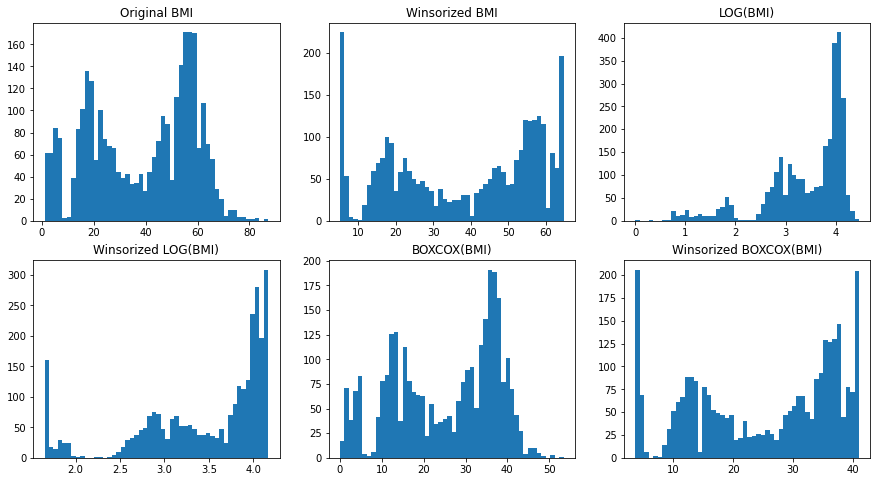

<IPython.core.display.Javascript object>

In [88]:
df2_2["Win_BMI"] = winsorize(df2_2[" BMI "], (0.05, 0.05))
df2_2["LOG(BMI)"] = np.log(df2_2[" BMI "])
df2_2["Win_LOG(BMI)"] = winsorize(df2_2["LOG(BMI)"], (0.05, 0.05))
df2_2["BOXCOX(BMI)"], _ = boxcox(df2_2[" BMI "])
df2_2["Win_BOXCOX(BMI)"] = winsorize(df2_2["BOXCOX(BMI)"], (0.05, 0.05))

plt.figure(figsize=(15, 8))
plt.subplot(231)
plt.title("Original BMI")
plt.hist(x=df2_2[" BMI "], bins=50)

plt.subplot(232)
plt.title("Winsorized BMI")
plt.hist(x=df2_2["Win_BMI"], bins=50)

plt.subplot(233)
plt.title("LOG(BMI)")
plt.hist(x=df2_2["LOG(BMI)"], bins=50)

plt.subplot(234)
plt.title("Winsorized LOG(BMI)")
plt.hist(x=df2_2["Win_LOG(BMI)"], bins=50)

plt.subplot(235)
plt.title("BOXCOX(BMI)")
plt.hist(x=df2_2["BOXCOX(BMI)"], bins=50)

plt.subplot(236)
plt.title("Winsorized BOXCOX(BMI)")
plt.hist(x=df2_2["Win_BOXCOX(BMI)"], bins=50)

plt.show()

In [ ]:
df2_2["Boxcox_Adult_Mort"], _ = boxcox(x=df2_2["Adult Mortality"])

plt.subplot(231)
plt.hist(x=df2_2["Adult Mortality"], bins=25)
plt.title("Original Adult Mortality")

plt.subplot(232)
plt.hist(x=df2_2["Boxcox_Adult_Mort"], bins=25)
plt.title("Boxcox(Adult Mortality)")

plt.subplot(233)
plt.hist(x=np.log(df2_2["Adult Mortality"]), bins=25)
plt.title("LOG(Adult Mortality)")

plt.subplot(234)
plt.hist(x=df2_2["Boxcox_Adult_Mort"], bins=25)
plt.title("Winsorized Boxcox(Adult Mortality)")

plt.subplot(235)
plt.hist(x=df2_2["Boxcox_Adult_Mort"], bins=25)
plt.title("Winsorized LOG(Adult Mortality)")

plt.show()
print(df2_2["Adult Mortality"].describe())
print(df2_2["Boxcox_Adult_Mort"].describe())
print(np.log(df2_2["Adult Mortality"]).describe())
print(winsorize(df2_2["Boxcox_Adult_Mort"], (0.05, 0.05)).describe())


In [ ]:
sns.pairplot(data=df2_2, hue="Status")
plt.show()

## 4. In the feature-engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are highly correlated with the other ones or the variables that you think are irrelevant with the life expectancy.

In [ ]:
df2_2.corr()

In [ ]:
df_num_corr = df2_2.corr()["Life expectancy "][:]  # -1 if 'a column'
golden_feature_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print(
    "There is {} strongly correlated values with a column:\n{}".format(
        len(golden_feature_list), golden_feature_list
    )
)

In [ ]:
HIV_boxcox,_ = boxcox(x=df2_2[' HIV/AIDS'])
